In [37]:
import os, random, json
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from typing import Optional

from src.utils.config import load_config, get_mean_std
from src.data.transforms import get_val_transforms
from src.models.build_model import build_model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


## Configuración
Ajuste las rutas al `config.yml`, `checkpoint` y a la lista de entrenamiento.

In [38]:
# Rutas: actualice según el modelo que quiera analizar
config_path = 'outputs_pth/fase3/swinv2_base_window16_256/config.yml'
checkpoint_path = 'outputs_pth/fase3/swinv2_base_window16_256/20251226_225355/phase2_epoch_40.pth'  # ejemplo, cambie a uno existente
train_list_path = 'lists/train.txt'
n_samples = 6  # cantidad de ejemplos a visualizar

# Carga de config
cfg = load_config(config_path)
mean, std = get_mean_std(cfg)
image_size = int(cfg.get('dataset', {}).get('image_size', 224))
num_classes = int(cfg.get('dataset', {}).get('num_classes', 2))
backbone_name = cfg.get('model', {}).get('backbone', 'vit_base_patch32_224')

# Opcional: cargar nombres de clases desde label_mapping.json si existe
label_index_to_name = None
lm_path = cfg.get('dataset', {}).get('label_mapping', None)
if lm_path and os.path.exists(lm_path):
    try:
        with open(lm_path, 'r', encoding='utf-8') as lf:
            lm_data = json.load(lf)
        # Si el JSON es {"name": idx}, invertimos
        inv = {}
        for k, v in lm_data.items():
            try:
                inv[int(v)] = str(k)
            except Exception:
                pass
        if inv:
            label_index_to_name = inv
    except Exception:
        label_index_to_name = None

# Construcción del modelo
model = build_model(backbone_name=backbone_name, pretrained=False, head_cfg=cfg.get('model', {}).get('head', {}), num_classes=num_classes)
model.to(device)
model.eval()
print('Backbone:', backbone_name, '| num_classes:', num_classes)

# Carga robusta del checkpoint
ckpt = torch.load(checkpoint_path, map_location=device)
state_dict = None
if isinstance(ckpt, dict):
    for key in ['model', 'state_dict', 'net', 'module']:
        if key in ckpt and isinstance(ckpt[key], dict):
            state_dict = ckpt[key]
            break
    if state_dict is None:
        # Puede ser un state_dict plano
        state_dict = ckpt
else:
    state_dict = ckpt
# Compatibilidad con claves 'backbone.'/'head.' dentro de Wrapper
missing, unexpected = model.load_state_dict(state_dict, strict=False)
print('Checkpoint cargado. Missing:', missing, '| Unexpected:', unexpected)

Backbone: swinv2_base_window16_256 | num_classes: 2


/tmp/ipykernel_11632/1676979479.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)


Checkpoint cargado. Missing: [] | Unexpected: []


## Muestreo de imágenes de entrenamiento
Se aplican transformaciones de validación para evaluación estable y se guardan las imágenes originales para superponer heatmaps.

In [39]:
# Transformaciones de validación
val_tf = get_val_transforms(image_size=image_size, mean=mean, std=std, aug_cfg=cfg.get('augmentations', {}).get('val', {}))

# Leer lista de train y seleccionar 3 malignas (1) y 3 benignas (0)
with open(train_list_path, 'r', encoding='utf-8') as f:
    lines = [ln.strip() for ln in f if ln.strip()]

pos_lines = []  # etiqueta 1 (maligna)
neg_lines = []  # etiqueta 0 (benigna)
for ln in lines:
    try:
        path, lbl = ln.rsplit(' ', 1)
        lbl = int(lbl)
        if lbl == 1:
            pos_lines.append(ln)
        else:
            neg_lines.append(ln)
    except Exception:
        continue

import random
random.seed(42)
sel_pos = random.sample(pos_lines, k=min(3, len(pos_lines)))
sel_neg = random.sample(neg_lines, k=min(3, len(neg_lines)))

if len(sel_pos) < 3:
    print(f"Aviso: solo se encontraron {len(sel_pos)} muestras malignas (se requieren 3)")
if len(sel_neg) < 3:
    print(f"Aviso: solo se encontraron {len(sel_neg)} muestras benignas (se requieren 3)")

samples = sel_pos + sel_neg

# Loader de imagen + tensor normalizado

def load_image_and_tensor(sample_line: str):
    path, label = sample_line.rsplit(' ', 1)
    label = int(label)
    img_bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        img_bgr = np.zeros((image_size, image_size, 3), dtype=np.uint8)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    aug = val_tf(image=img_rgb)
    img_norm = aug['image']  # HxWxC, normalizado
    x = torch.from_numpy(img_norm.transpose(2, 0, 1)).float().unsqueeze(0).to(device)
    return img_rgb, x, label, path

print('Seleccionadas:', len(sel_pos), 'malignas y', len(sel_neg), 'benignas')
display([s[:100] + '...' if len(s)>100 else s for s in samples])

Seleccionadas: 3 malignas y 3 benignas


['/mnt/c/Users/eddyarias/Sovos/Sovos-Per-Emp/TIC/DataTIC/ISIC/2019/train/ISIC_0068291.jpg 1',
 '/mnt/c/Users/eddyarias/Sovos/Sovos-Per-Emp/TIC/DataTIC/ISIC/2019/train/ISIC_0071700.jpg 1',
 '/mnt/c/Users/eddyarias/Sovos/Sovos-Per-Emp/TIC/DataTIC/ISIC/2019/train/ISIC_0065174.jpg 1',
 '/mnt/c/Users/eddyarias/Sovos/Sovos-Per-Emp/TIC/DataTIC/ISIC/2020/train/ISIC_7049334.jpg 0',
 '/mnt/c/Users/eddyarias/Sovos/Sovos-Per-Emp/TIC/DataTIC/ISIC/2018/train/ISIC_0029674.jpg 0',
 '/mnt/c/Users/eddyarias/Sovos/Sovos-Per-Emp/TIC/DataTIC/ISIC/2020/train/ISIC_8638021.jpg 0']

## Funciones de explicabilidad
Implementación de SmoothGrad, Integrated Gradients (IG) y TIS (Token Importance Score) para visualizar contribuciones.

In [40]:
# SmoothGrad: promedio de gradientes con ruido
def smoothgrad_heatmap(model, x: torch.Tensor, target_class: Optional[int], n_samples: int = 25, sigma: float = 0.1):
    model.zero_grad()
    x.requires_grad_(True)
    B, C, H, W = x.shape
    grads = []
    for _ in range(n_samples):
        noise = torch.randn_like(x) * sigma
        xn = (x + noise).clamp(-10, 10)
        logits = model(xn)
        if target_class is None:
            target = logits.argmax(dim=1)
        else:
            target = torch.tensor([target_class], device=logits.device)
        loss = logits[0, target.item()]
        model.zero_grad()
        if x.grad is not None:
            x.grad.zero_()
        loss.backward(retain_graph=True)
        grads.append(x.grad.detach().abs())
    g = torch.stack(grads, dim=0).mean(dim=0)[0]  # CxHxW
    g = g.sum(dim=0)  # HxW
    g = (g - g.min()) / (g.max() - g.min() + 1e-8)
    return g.cpu().numpy()


In [41]:
import math
import numpy as np

# Integrated Gradients sobre la entrada
# Devuelve un heatmap 2D normalizado [0,1]
def integrated_gradients_heatmap(model, x: torch.Tensor, target_class: Optional[int], steps: int = 50, baseline: Optional[torch.Tensor] = None):
    model.eval()
    if baseline is None:
        baseline = torch.zeros_like(x)
    # Asegurar tensores desacoplados
    x = x.detach()
    baseline = baseline.detach()
    delta = x - baseline
    grads = []
    for alpha in torch.linspace(0.0, 1.0, steps, device=x.device):
        x_alpha = baseline + alpha * delta
        x_alpha.requires_grad_(True)
        logits = model(x_alpha)
        if target_class is None:
            target = logits.argmax(dim=1)
        else:
            target = torch.tensor([target_class], device=logits.device)
        loss = logits[0, target.item()]
        model.zero_grad()
        if x_alpha.grad is not None:
            x_alpha.grad.zero_()
        loss.backward(retain_graph=True)
        grads.append(x_alpha.grad.detach())
    avg_grads = torch.stack(grads, dim=0).mean(dim=0)[0]  # CxHxW
    ig = (delta[0] * avg_grads).sum(dim=0).abs()  # HxW
    ig = (ig - ig.min()) / (ig.max() - ig.min() + 1e-8)
    return ig.cpu().numpy()

## Visualización en matriz
Se muestra por fila: Imagen, SmoothGrad, Integrated Gradients y TIS (Token Importance Score).

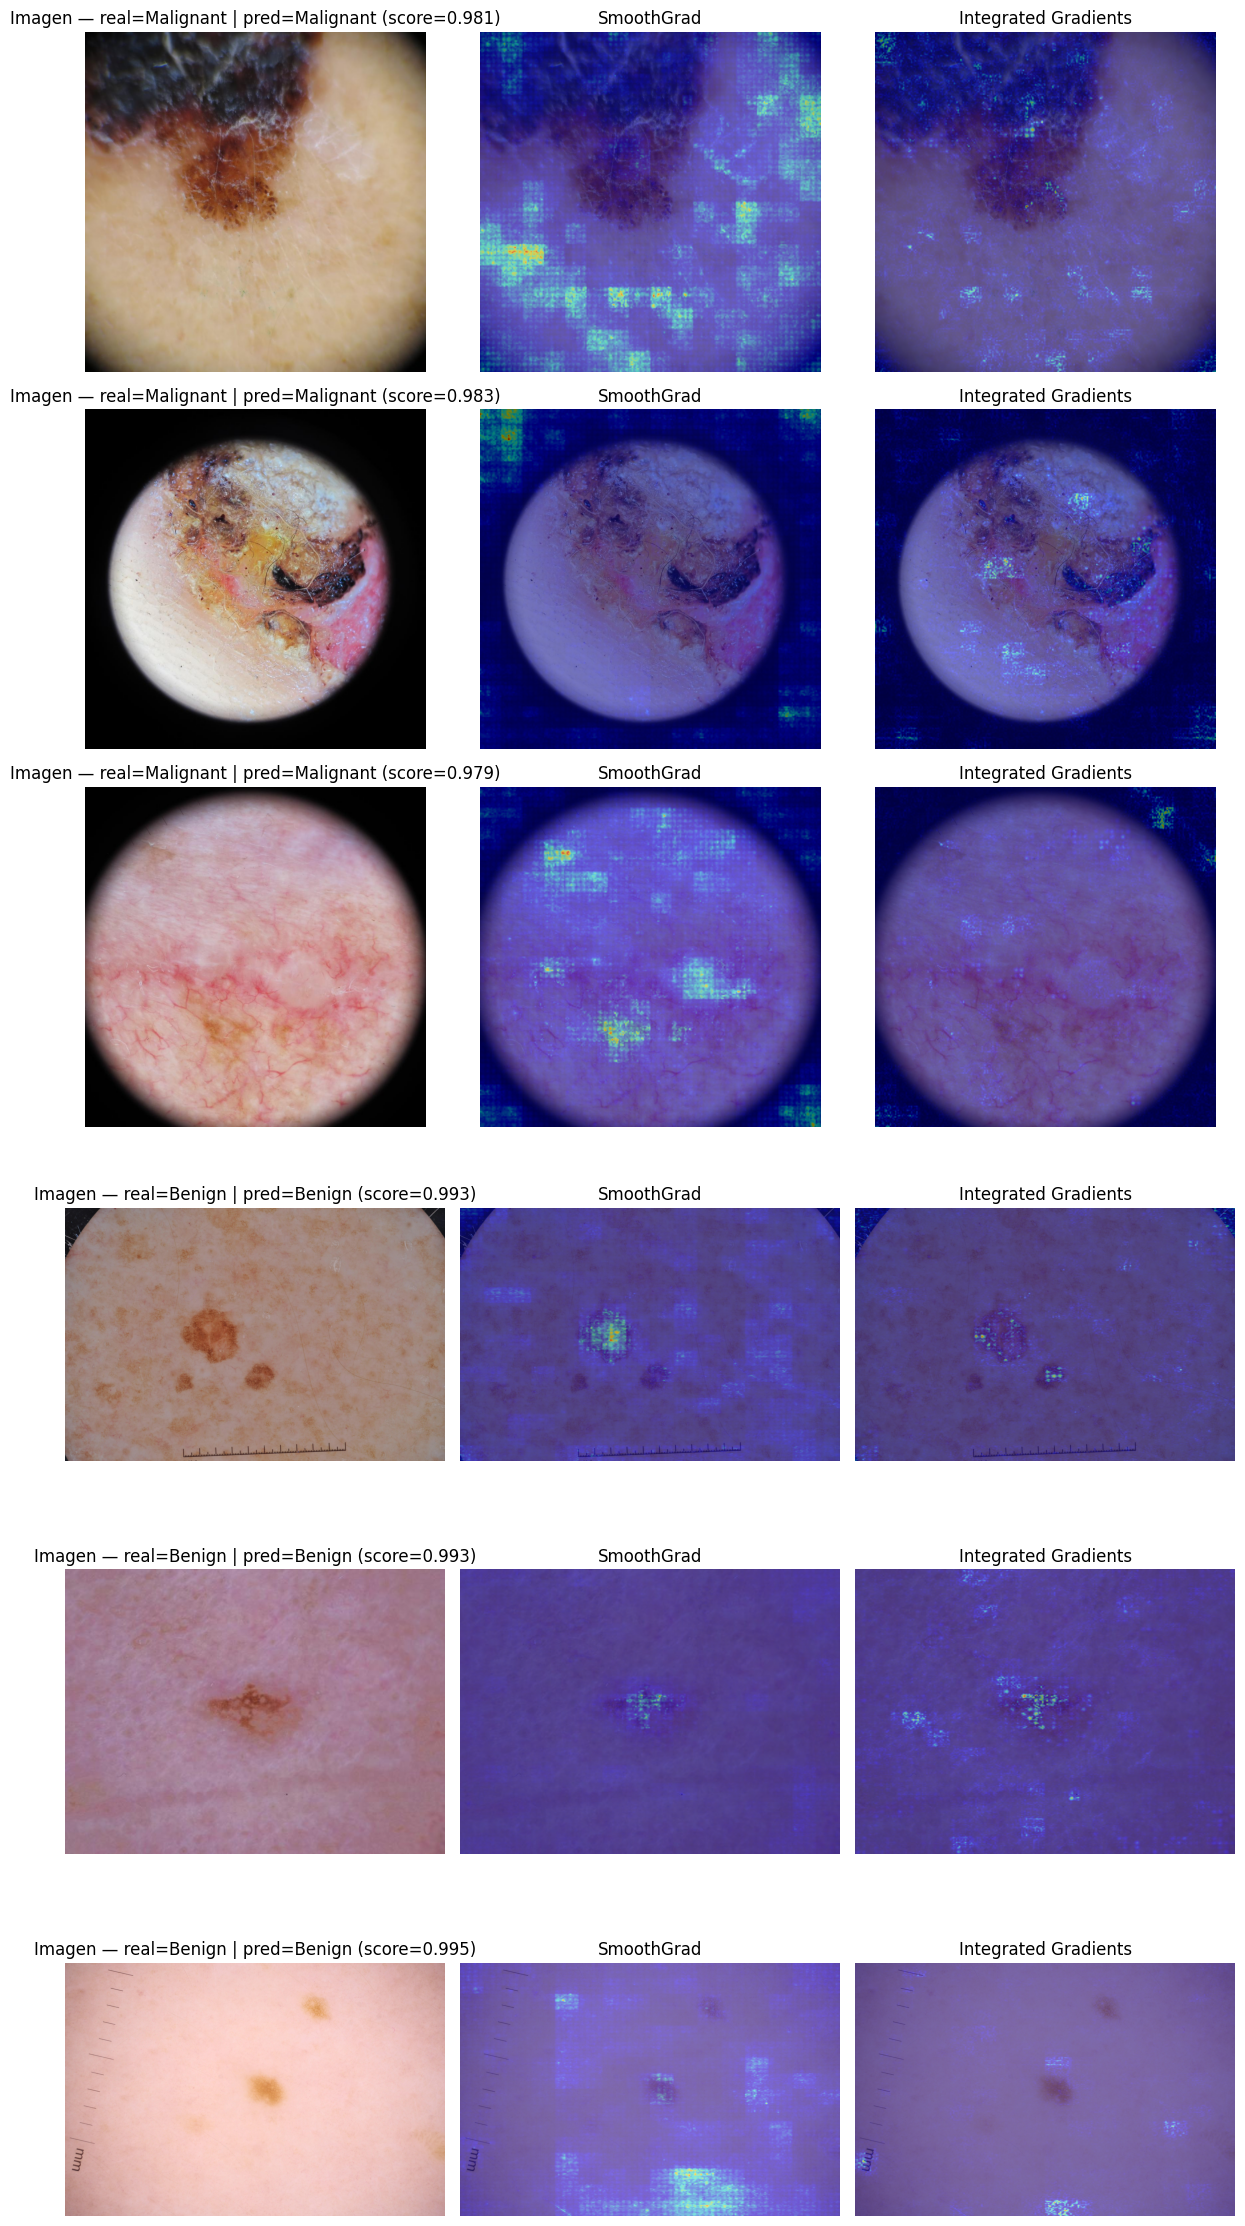

In [42]:
def overlay_heatmap(img_rgb: np.ndarray, heatmap: np.ndarray, alpha: float = 0.5, cmap: str = 'jet'):
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, getattr(cv2, f'COLORMAP_{cmap.upper()}', cv2.COLORMAP_JET))
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    overlay = np.clip(alpha * heatmap_color + (1-alpha) * img_rgb, 0, 255).astype(np.uint8)
    return overlay

# Helper para nombre de clase
def _label_text(idx: int):
    global label_index_to_name
    if label_index_to_name and idx in label_index_to_name:
        return label_index_to_name[idx]
    return f"Clase {idx}"

rows = len(samples)
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.8*rows))
if rows == 1:
    axes = np.expand_dims(axes, 0)

for i, sline in enumerate(samples):
    img_rgb, x, label, path = load_image_and_tensor(sline)
    # Predicción del modelo + probabilidad/score
    with torch.no_grad():
        logits = model(x)
        # Softmax para probas
        probs = torch.softmax(logits, dim=1)
        pred = int(torch.argmax(probs, dim=1).item())
        score = float(probs[0, pred].item())
    sg = smoothgrad_heatmap(model, x.clone(), target_class=pred, n_samples=20, sigma=0.08)
    ig = integrated_gradients_heatmap(model, x.clone(), target_class=pred, steps=40)
    # Reescalar heatmaps al tamaño de la imagen
    def resize_map(m):
        return cv2.resize(m.astype(np.float32), (img_rgb.shape[1], img_rgb.shape[0]), interpolation=cv2.INTER_LINEAR)
    sg_r = resize_map(sg)
    ig_r = resize_map(ig)
    # Overlays
    ov_sg = overlay_heatmap(img_rgb, sg_r, alpha=0.5, cmap='jet')
    ov_ig = overlay_heatmap(img_rgb, ig_r, alpha=0.5, cmap='jet')
    # Textos
    real_txt = _label_text(int(label))
    pred_txt = _label_text(pred)
    title_info = f"real={real_txt} | pred={pred_txt} (score={score:.3f})"
    # Plot
    axes[i,0].imshow(img_rgb)
    axes[i,0].set_title(f'Imagen — {title_info}')
    axes[i,0].axis('off')
    axes[i,1].imshow(ov_sg)
    axes[i,1].set_title('SmoothGrad')
    axes[i,1].axis('off')
    axes[i,2].imshow(ov_ig)
    axes[i,2].set_title('Integrated Gradients')
    axes[i,2].axis('off')

plt.tight_layout()
plt.show()